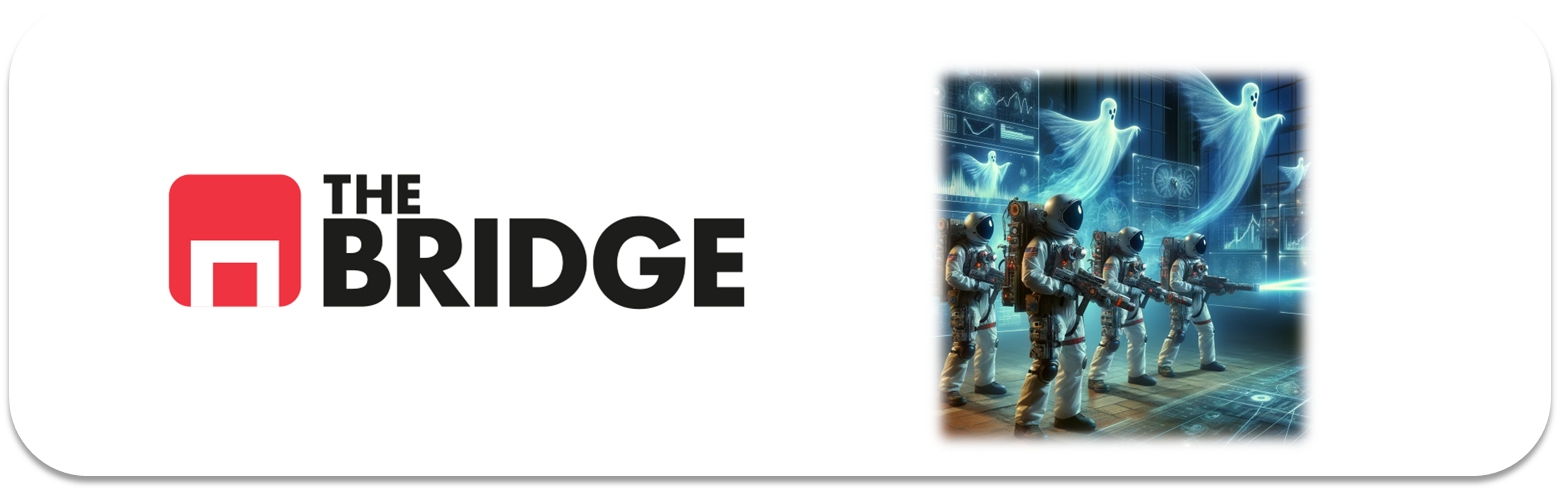

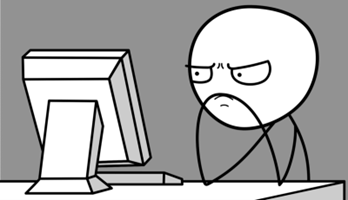

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [2]:
df= pd.read_csv("./data/AirPassengers.csv")
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [3]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")
df

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

- El histórico va desde el 01-01-1949 al 01-12-1960 con una periodicidad de mes a mes

### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

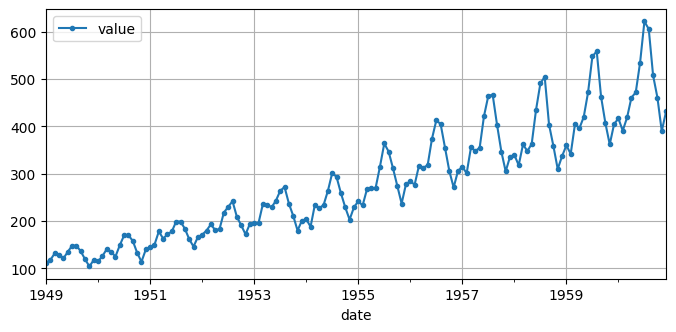

In [5]:
df["1949-01":"1960-12"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

- Es una serie univariada, mirando la gráfica pareciera que hubiera estacionalidad anual, vemos que hay un pico que coincide con los meses de verano.

In [6]:
period = slice("1949", "1960")
df_mean = df.resample('M').mean()  
rolling_average_12_months = df_mean[period].rolling(window=12).mean()

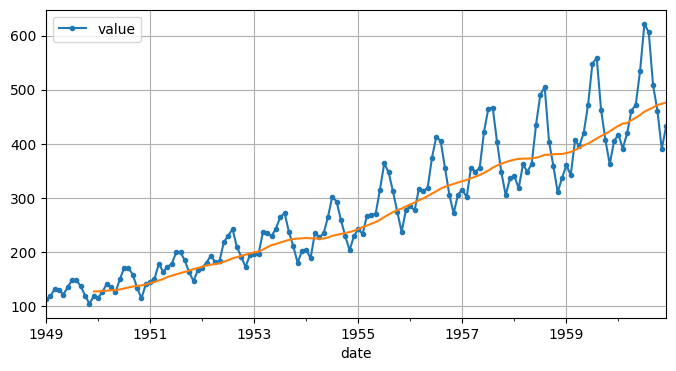

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
df_mean[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

- Viendo esta gráfica podemos deducir que existe una estacionalidad anual y que hay una tendencia a subir cada año, y volvemos a apreciar ese pico para los meses de veranos.

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

- 1º manera: Test de hipótesis (test de Dickey-Fuller Aumenatdo o ADFuller)

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.values)
result[1]

0.991880243437641

- Rechazamos la hipotesis nula de NO estacionariedad.

### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df, model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(df, model = 'additive', extrapolate_trend = 'freq')


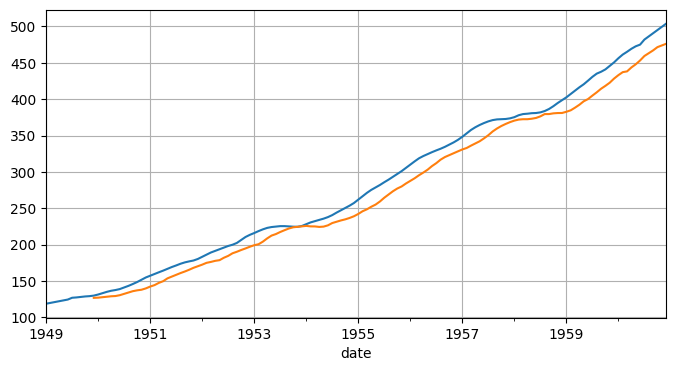

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
result_mul.trend.plot();
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

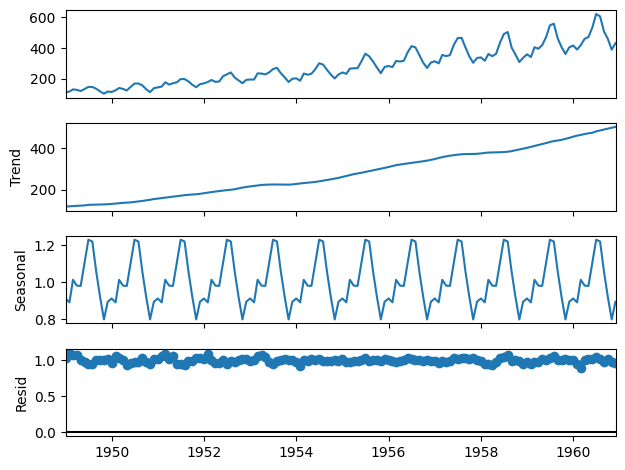

In [11]:
result_mul.plot();

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

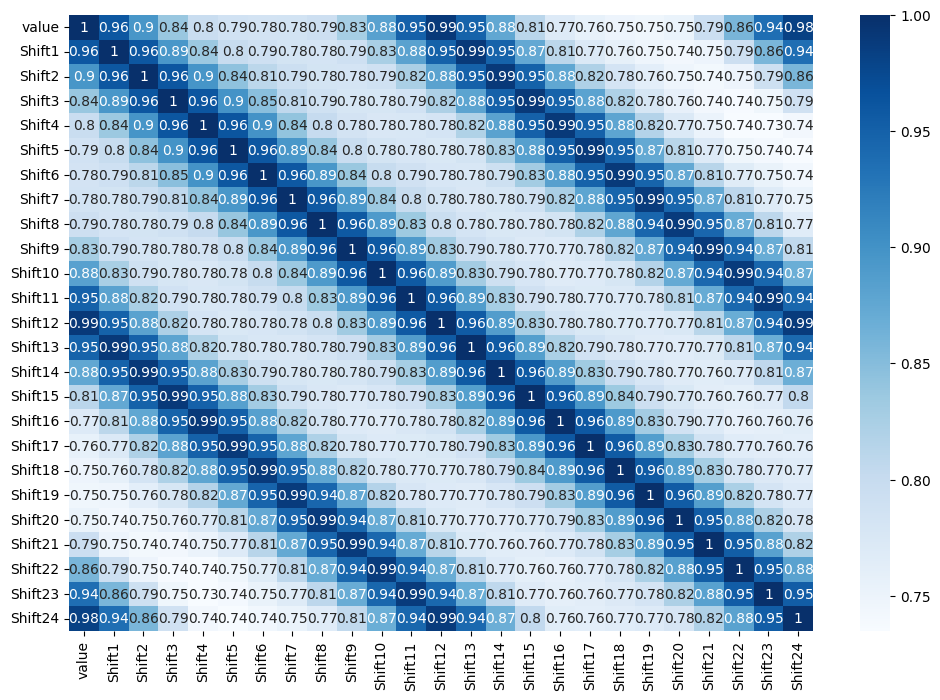

In [30]:
df_shift = df.copy()
for i in range(1,25):
    df_shift[f"Shift{i}"]= df_shift["value"].shift(i)
df_corr = df_shift.corr()
df_corr
plt.figure(figsize=(12,8))
sns.heatmap(df_corr, annot=True, cmap='Blues')

plt.show()

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

- Se cumple cada 12 instantes

### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [12]:
df

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [13]:
X_train = df["value"].iloc[0:124]
X_test = df["value"].iloc[124:]

### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

In [14]:
model = auto_arima(X_train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   trace= True,
                   stepwise = False) 

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1180.340, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1171.576, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1174.338, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1164.464, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1171.757, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=1171.514, Time=0.1

RMSE: 93.54868540548213
MAPE: 13.17%


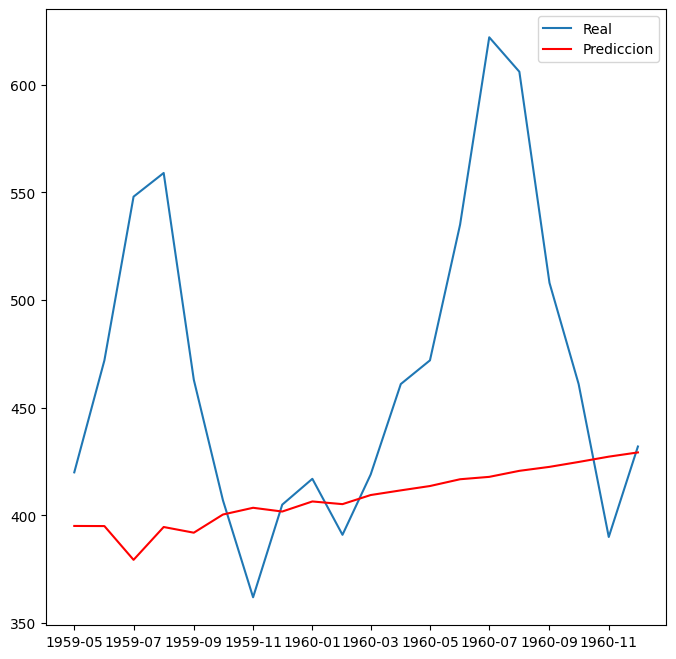

In [16]:
y_pred = model.predict(20) 
error_rmse = np.sqrt(mean_squared_error(X_test, y_pred))
error_mape = mean_absolute_percentage_error(X_test, y_pred)
print(f'RMSE: {error_rmse}')
print(f"MAPE: {round(error_mape * 100,2)}%")

plt.figure(figsize = (8,8))
plt.plot(X_test, label = "Real")
plt.plot(y_pred, color='red', label = "Prediccion")
plt.legend();


### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [17]:
sarima = auto_arima(X_train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12,
                    trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=942.581, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=841.692, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=890.316, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1100.615, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=841.349, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=841.921, Time=0.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=841.844, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=842.275, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=889.425, Time=0.07 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=842.600, Time=0.27 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=849.916, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 2.720 seconds


RMSE: 30.673685879922207
MAPE: 5.86%


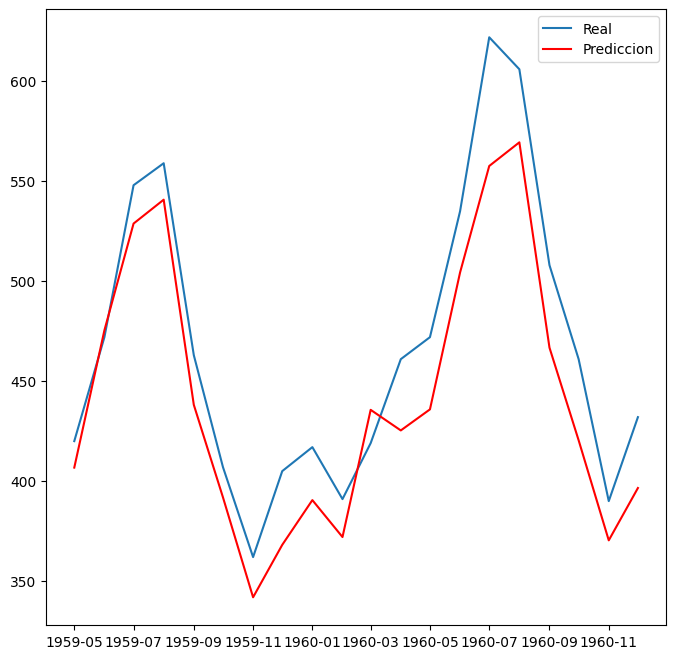

In [19]:
y_pred_sarima = sarima.predict(20) 
error_rmse = np.sqrt(mean_squared_error(X_test, y_pred_sarima))
error_mape = mean_absolute_percentage_error(X_test, y_pred_sarima)
print(f'RMSE: {error_rmse}')
print(f"MAPE: {round(error_mape * 100,2)}%")

plt.figure(figsize = (8,8))
plt.plot(X_test, label = "Real")
plt.plot(y_pred_sarima, color='red', label = "Prediccion")
plt.legend();
